In [27]:
!pip install validclust
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import tensorflow as tf
from keras.datasets import cifar10
import cv2 
import random
from validclust import dunn
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Input,Reshape,UpSampling2D,BatchNormalization
from keras.models import Model,Sequential

In [28]:
#Loading data
(trainX, trainy), (testX, testy) = cifar10.load_data()
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [29]:
#Converting image to grayscale to reduce dimensionality
testX_gray = np.zeros((10000,32,32))
for i, img in enumerate(testX):
    testX_gray[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [30]:
#Normalization
testX_gray = testX_gray.reshape(len(testX_gray), -1)
testX_gray = testX_gray.astype('float32')
testX_gray = testX_gray/255.0

In [31]:
testX_gray.shape

(10000, 1024)

In [32]:
#Initializing all variables
k = 10
clusters = {}
centroids = []
labels = np.zeros(10000)
for i in range(k):
    clusters[i] = []

In [33]:
#Choosing random images as initial clusters
random.seed(4)
r = random.sample(range(1,10000), 10)
for i in r:
    centroids.append(testX_gray[i])

In [34]:
#Functions for recalculating clusters and centroids
def new_clusters(testX_gray, centroids, k):
    clusters = {}
    for i in range(k):
        clusters[i] = []
    for i, image in enumerate(testX_gray):
        dist = []
        for j in range(k):
            dist.append(np.linalg.norm(image - centroids[j]))
        clusters[dist.index(min(dist))].append(image)
        labels[i] = dist.index(min(dist))
    return clusters

def new_centroids(centroids, clusters, k):
    centroids = []
    for i in range(k):
        centroids.append(np.average(clusters[i], axis=0))
    return centroids

In [35]:
#Function for kmeans clustering
def k_means_clustering(testX_gray, centroids=[], k=10, flag=1, count=0):
    while flag:
        old_centroids = centroids
        clusters = new_clusters(testX_gray, centroids, k)  
        centroids = new_centroids(centroids, clusters, k)
        for i in range(k):
            if not np.allclose(centroids[i], old_centroids[i], atol = 0.5):
                flag = 1
                break
            flag = 0
    
    return clusters, centroids

In [10]:
#Executing kmeans clustering
clusters, centroids = k_means_clustering(testX_gray, centroids)

In [11]:
#Calculating distance matrix for dunn index
pair_dist = pairwise_distances(testX_gray)

In [12]:
#Average Silhouette Coeficient
print(silhouette_score(testX_gray, labels))

0.06360983


In [13]:
#Dunn's index
print(dunn(pair_dist, labels))

0.09712669


In [36]:
#Normalizing training data for part 2
trainX = trainX.astype('float32')
trainX = trainX/255.0
testX = testX.astype('float32')
testX = testX/255.0

In [37]:
#Constructing autoencoder
autoencoder = Sequential()
autoencoder.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same', input_shape=testX.shape[1:]))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(16, (3, 3), strides=(2,2), activation='relu', padding='same'))

#For extracting encoded images 
autoencoder.add(Flatten())
autoencoder.add(Reshape((8, 8, 16)))

autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [38]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 16)          0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 16, 16, 16)       0         
 2D)                                                  

In [40]:
#Extracting encoded images
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten').output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8_input (InputLayer)  [(None, 32, 32, 3)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
Total params: 5,648
Trainable params: 5,584
Non-trainable params: 64
________________________________________________________

In [41]:
#Fitting autoencoder on training data
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
trained_autoencoder = autoencoder.fit(trainX, trainX,
                epochs=50,
                batch_size=128,
                validation_data=(testX, testX))

Epoch 1/50
391/391 [==============================] - 9s 20ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 6/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/50
391/391 [==============================] - 7s 19ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/50
391/391 [==============================] - 8s 19ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/50
391/391 [==============================] - 8s 21ms/step - loss: 0.0023 - val_lo

In [42]:
trainX_auto = autoencoder.predict(trainX) #autoencoder
trainX_enc = encoder.predict(trainX) #encoded

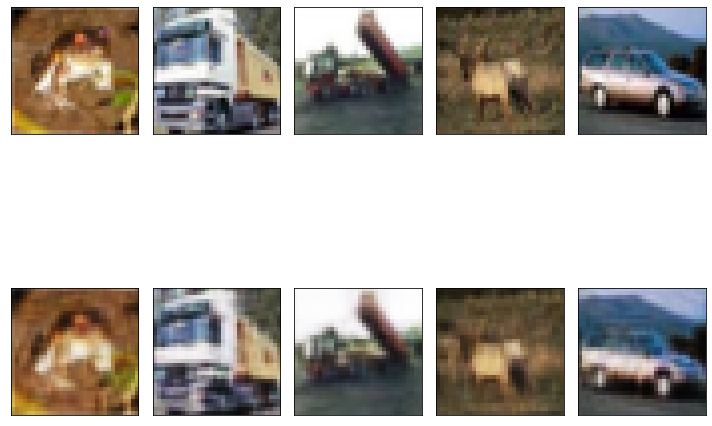

In [43]:
#Displaying first 5 images of training data and autoencoder generated data
fig = plt.figure(figsize=(10, 10))
for i in range(1, 6):
    img = trainX[i-1]
    fig.add_subplot(2, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
for i in range(1, 6):
    img = trainX_auto[i-1]
    fig.add_subplot(2, 5, i+5)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [44]:
kmeans = KMeans(n_clusters=10).fit(trainX_enc)
labels_kmeans = kmeans.labels_

In [45]:
#Average Silhouette Coeficient
print(silhouette_score(trainX_enc, labels_kmeans))

0.017512273
